# construct network for foreground removal in baseline / visibility space

In [3]:
import tensorflow as tf
print(tf.__version__)

import h5py
import healpy as hp

import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import jax

import jaxlib

import numpy as np

print('jax version: ', jax.__version__)
print('jaxlib version: ', jaxlib.__version__)

# matplotlib stuff
import matplotlib.pyplot as plt

# flax import
import flax.linen as nn
import optax


rng = random.PRNGKey(2)

2.8.3
jax version:  0.3.17
jaxlib version:  0.3.15


In [4]:
# load data
fnames_cosmo = ['/data80/makinen/hirax_sims/cora21cm_%d.h5'%(i+1) for i in range(5)]
fnames_gal   = ['/data80/makinen/hirax_sims/coragalaxy_%d.h5'%(i+1) for i in range(5)]

outstems_cosmo = ['/data80/makinen/hirax_sims/cora21cm_%d_'%(i+1) for i in range(5)]
outstems_gal = ['/data80/makinen/hirax_sims/coragalaxy_%d_'%(i+1) for i in range(5)]

# load data, taking first 12 baselines

# data shape: 5sims, 1024 RA, 128 freqs, 15 baselines
cosmo_vis = np.array([np.load(outstems_cosmo[i] + 'visibilities.npy') for i in range(5)]).reshape(5, 1024, 128, 15)[:, :, :, :12]
gal_vis = np.array([np.load(outstems_gal[i] + 'visibilities.npy') for i in range(5)]).reshape(5, 1024, 128, 15)[:, :, :, :12]

# flatten batch in first two dimensions
cosmo_vis = cosmo_vis.reshape(5*1024, 128, 12)
gal_vis = gal_vis.reshape(5*1024, 128, 12)

obs_vis = cosmo_vis + gal_vis

# train and validation split -- do abs(ai + b) = sqrt(a^2 + b^2)
train_idx = 4*1024

x_train = np.abs(obs_vis[:train_idx])
x_val = np.abs(obs_vis[train_idx:])

y_train = np.abs(cosmo_vis[:train_idx])
y_val = np.abs(cosmo_vis[train_idx:])

# split into real and im parts
#np.imag(cosmo_val).shape

# PCA module in Jax

In [5]:
from functools import partial 
@partial(jax.jit, static_argnums=1)
def pca_subtraction(X, n_comp=3):
    # Data matrix X, shaped (-1, featureaxis)
    n, m = X.shape

    # calculate mean
    mu = X.mean(axis=0)

    X -= mu

    # DO PCA 

    # Compute covariance matrix
    C = jnp.dot(X.T, X) / (n-1)
    # Eigen decomposition
    eigen_vals, eigen_vecs = jnp.linalg.eigh(C)
    
    # TEST: TRASFORM EIGENVECS
    #eigen_vecs *= noise
    
    # Project X onto PC space
    X_pca = jnp.dot(X, eigen_vecs)

    ind_arr = jnp.reshape(jnp.arange(n*m),X.shape)

    mask = jnp.ones((n,m))

    component_mask = ind_arr%m
    
    comps_to_keep = jnp.arange(n_comp, m)
    
    mask_of_comps_to_keep = jnp.in1d(component_mask.flatten(), 
                                     comps_to_keep).reshape(component_mask.shape) # returns boolean mask

    # now use the mask's mask to set zeros for the stuff we don't want
    # does the same as: for i in range(n_comp, m): mask = mask.at[ind_arr%m == i].set(0.)
    mask = jnp.where(mask_of_comps_to_keep == 0, 0., mask)

    
    X_pca = X_pca*mask


    
    # inverse pca-transform !
    X_pca_inv = jnp.dot(X_pca, eigen_vecs.T)
    
        # the PCA residual   
    X_res = X - X_pca_inv

    return X_res, eigen_vecs

# network code

In [14]:
from typing import Any, Callable, Sequence, Optional
from flax.core import freeze, unfreeze
from functools import partial

# flax import
import flax.linen as nn
import optax


import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import jax



class AsinhLayer(nn.Module):
    bias_init: Callable = nn.initializers.zeros
    a_init: Callable = nn.initializers.ones
    b_init: Callable = nn.initializers.ones
    c_init: Callable = nn.initializers.zeros
    d_init: Callable = nn.initializers.zeros
    
    @nn.compact
    def __call__(self, inputs):

        a = self.param('a', self.a_init, (1,))
        b = self.param('b', self.b_init, (1,))
        c = self.param('c', self.c_init, (1,))
        d = self.param('d', self.d_init, (1,)) 

        y = a*jnp.arcsinh(b*inputs + c) + d
        return y
    


class Sequential(nn.Module):
    layers: Sequence[nn.Module]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class ConvBlock(nn.Module):
    filters: int
    strides: int
    dim: int = 3
    kernel: int = 3
    act: Callable = nn.relu
    padding: str = 'SAME'

    @nn.compact
    def __call__(self, x):
        k = self.kernel
        fs = self.filters
        x = nn.Conv(features=fs, kernel_size=(k,)*self.dim, 
                    strides=self.strides, padding=self.padding)(x)
        x = self.act(x)
        return x

class DoubleConvBlock(nn.Module):
    filters: int
    strides: int
    dim: int = 3
    kernel: int = 3
    act: Callable = nn.relu
    padding: str = 'SAME'

    @nn.compact
    def __call__(self, x):
        k = self.kernel
        fs = self.filters
        x = nn.Conv(features=fs, kernel_size=(k,)*self.dim, 
                    strides=self.strides, padding=self.padding)(x)
        x = self.act(x)
        x = nn.Conv(features=fs, kernel_size=(k,)*self.dim, 
                    strides=self.strides, padding=self.padding)(x)
        x = self.act(x)
        return x
    
class unet(nn.Module):
    """a unet-encoder module"""
    filters : int
    act: Callable = nn.relu
    dim: int = 3
    padding: str = "SAME"

    @nn.compact
    def __call__(self, x):

        fs = self.filters
        padding = self.padding
        _shape = x.shape
        d = self.dim
        
        x = AsinhLayer()(x)
        
        # downsample
        x1 = DoubleConvBlock(fs, strides=None, act=self.act, padding=padding, dim=d)(x)
        x = ConvBlock(fs, strides=2, act=self.act, padding=padding)(x1) # down to 8
        x2 = DoubleConvBlock(fs*2, strides=None, act=self.act, padding=padding, dim=d)(x)
        x = ConvBlock(fs*2, strides=2,act=self.act, padding=padding, dim=d)(x2) # down to 4
        x = DoubleConvBlock(fs*4, strides=None, act=self.act, padding=padding, dim=d)(x) 

        # upsample path
        x = nn.ConvTranspose(features=fs*4, kernel_size=(1,)*d, strides=(2,)*d, padding=padding)(x) # upsample to 8
        x = self.act(x)
        x = jnp.concatenate([x,x2], axis=-1)
        x = DoubleConvBlock(fs*2, strides=None, act=self.act, padding=padding, dim=d)(x) 
        x = nn.ConvTranspose(features=fs*2, kernel_size=(1,)*d, strides=(2,)*d, padding=padding)(x) # upsample to 16
        x = self.act(x)
        x = jnp.concatenate([x,x1], axis=-1) # filters add to fs*2
        x = DoubleConvBlock(fs, strides=None,act=self.act, padding=padding, dim=d)(x) 
        x = nn.ConvTranspose(features=1, kernel_size=(3,)*d, strides=None, padding=padding)(x)

        return x
    

    
class pca_layer(nn.Module):
    """network with learnable PCA latent space"""
    n_comp : int
    act: Callable = nn.relu
    padding: str = "SAME"
    kernel: int = 3
    dim: int=3
    
    @nn.compact
    def __call__(self, x):
        
        X = x #jnp.squeeze(x)
        n_comp = self.n_comp
        k = self.kernel
        
        # Data matrix X, shaped (-1, featureaxis)
        n, m = X.shape

        # calculate mean
        mu = X.mean(axis=0)

        X -= mu

        # DO PCA 

        # Compute covariance matrix
        C = jnp.dot(X.T, X) / (n-1)
        # Eigen decomposition
        eigen_vals, eigen_vecs = jnp.linalg.eigh(C)
        
        print('evecs', eigen_vecs.shape)

        # TEST: TRASFORM EIGENVECS WITH CONV NET
        #eigen_vecs = nn.Conv(features=1, kernel_size=(k,)*2, # dim is 2 for e'vec matrix
                        #strides=1, padding=self.padding)(jnp.expand_dims(eigen_vecs, -1))
            
        eigen_vecs = unet(filters=8, act=nn.relu, dim=2, padding="SAME")(
                                                jnp.expand_dims(
                                                    jnp.expand_dims(eigen_vecs, -1), 0))
        
        eigen_vecs = nn.tanh(eigen_vecs)
        
        eigen_vecs = jnp.squeeze(eigen_vecs)
        
        print('evec outshape', eigen_vecs.shape)

        # Project X onto PC space
        X_pca = jnp.dot(X, eigen_vecs)

        ind_arr = jnp.reshape(jnp.arange(n*m),X.shape)

        mask = jnp.ones((n,m))
        component_mask = ind_arr%m
        comps_to_keep = jnp.arange(n_comp, m)
        mask_of_comps_to_keep = jnp.in1d(component_mask.flatten(), 
                                         comps_to_keep).reshape(component_mask.shape) # returns boolean mask

        # now use the mask's mask to set zeros for the stuff we don't want
        # does the same as: for i in range(n_comp, m): mask = mask.at[ind_arr%m == i].set(0.)
        mask = jnp.where(mask_of_comps_to_keep == 0, 0., mask)


        X_pca = X_pca*mask

    
        # inverse pca-transform !
        X_pca_inv = jnp.dot(X_pca, eigen_vecs.T)

            # the PCA residual   
        X_res = X - X_pca_inv
        
        # do some extra learning on the residual
        #fs = self.filters
        #X_res = DoubleConvBlock(fs*2, strides=None, act=self.act, padding=padding)(x) 

        return X_res, eigen_vecs
        
        
class pca_net(nn.Module):
    """network with learnable PCA latent space"""
    n_comp : int
    act: Callable = nn.relu
    padding: str = "SAME"
    kernel: int = 3
    dim: int=3
    
    @nn.compact
    def __call__(self, x):
        print('input shape', x.shape)
        x, evecs = jax.vmap(pca_layer(self.n_comp, self.act))(x)
        
        print('output shape', x.shape)
        
        return x #, evecs

In [15]:
x_test = x_val.reshape(1024*12, 128)
y_test = y_val

In [16]:
transform_test, evecs = pca_subtraction(x_test.reshape(1024*12, 128), n_comp=18)

In [17]:

rng = jax.random.PRNGKey(42)
shape = (1024,128,12)

key,rng = jax.random.split(rng, num=2)

#input_shape = (12,) + shape + (1,)

model = pca_net(6, jax.nn.leaky_relu)

dummy_x = jnp.expand_dims(x_test[:1024*12], 0)

# INITIAL PARAMS
initial_w = model.init(key, dummy_x)
# DUMMY OUTPUT
output = model.apply(initial_w, dummy_x) #[0]

input shape (1, 12288, 128)
evecs (128, 128)
evec outshape (128, 128)
output shape (1, 12288, 128)
input shape (1, 12288, 128)
evecs (128, 128)
evec outshape (128, 128)
output shape (1, 12288, 128)


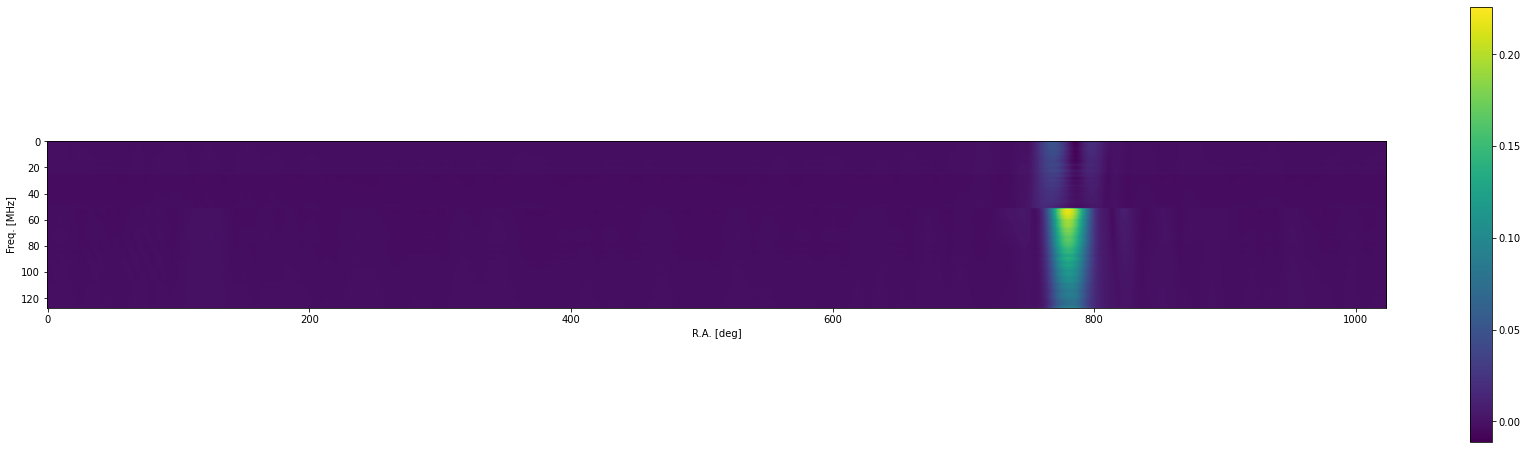

In [18]:
plt.figure(figsize=(30, 8))
plt.imshow(jnp.arcsinh(output.reshape(1024, 12, 128))[:, 6, :].T)
#plt.title(r'$\arcsinh|\mathcal{V}|$; ' + baseline_tag)
plt.ylabel('Freq. [MHz]')
plt.xlabel('R.A. [deg]')
plt.colorbar()

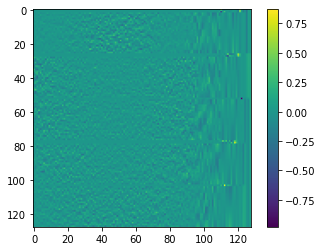

In [20]:
plt.imshow(evecs)
plt.colorbar()

In [21]:
batch_size = 12
filters = 16

# model helper function
def get_model(filters=filters, act=nn.relu):
  return pca_net(3, jax.nn.leaky_relu)

In [22]:
# loss functions
@jax.vmap
def kl_divergence(mean, logvar):
  return -0.5 * jnp.sum(1 + logvar - jnp.square(mean) - jnp.exp(logvar))


@jax.vmap
def binary_cross_entropy_with_logits(logits, labels):
  logits = nn.log_sigmoid(logits)
  return -jnp.sum(labels * logits + (1. - labels) * np.log(-np.expm1(logits)))

@jax.vmap
def log_square_error(preds, targets):
  #targets = jnp.log(targets + 1.)
  return jnp.log((preds - targets)**2)

@jax.vmap
def L1_error(preds, targets):
  targets = jnp.log(targets + 1.)
  errors = preds - targets
  return jnp.logaddexp(errors, -errors) - jnp.log(2.0)


def compute_metrics(recon_x, x):
  mse_loss = log_square_error(recon_x, x).mean()
  return {
      'mse': mse_loss
  }



@jax.jit
def train_step(state, x, y):
  def loss_fn(params):
    recon_x = get_model().apply({'params': params}, x)

    mse_loss = log_square_error(recon_x, y).mean()
    loss = mse_loss
    return loss
  grads = jax.grad(loss_fn)(state.params)
  return state.apply_gradients(grads=grads)


@jax.jit
def myeval(params, x, y):
  def loss_fn(params):
    recon_x = get_model().apply({'params': params}, x)

    mse_loss = log_square_error(recon_x, y).mean()
    loss = mse_loss
    return loss
  loss = loss_fn(params)
  return loss

# @jax.jit
# def myeval(params, x, y):
#   def eval_model(pca_net):
#     recon_images,evecs = pca_net(x)

#     metrics = compute_metrics(recon_images, y)
#     return metrics 

#   return nn.apply(eval_model, get_model())({'params': params})


@jax.jit
def eval_with_comparison(params, x, y):
  def eval_model(pca_net):
    recon_images = pca_net(x)


    metrics = compute_metrics(recon_images, y)
    return metrics

  return nn.apply(eval_model, get_model())({'params': params})

In [23]:
from tqdm import tqdm

In [24]:
output.shape

(1, 12288, 128)

In [25]:
jnp.array(jnp.split(x_train, 1)).shape

(1, 4096, 128, 12)

In [26]:
from sklearn.model_selection import train_test_split





In [27]:
x_train.shape

(4096, 128, 12)

In [28]:
# train and validation split -- do abs(ai + b) = sqrt(a^2 + b^2)
train_idx = 4*1024

_x_train = jnp.array(jnp.split(x_train.reshape(-1, 128), 4))
_x_val = jnp.array(jnp.split(x_val.reshape(-1, 128), 1))

_y_train = jnp.array(jnp.split(y_train.reshape(-1, 128), 4))
_y_val = jnp.array(jnp.split(y_val.reshape(-1, 128), 1))

_x_train = jax.device_put(_x_train)
_y_train = jax.device_put(_y_train)

_x_val = jax.device_put(_x_val)
_y_val = jax.device_put(_y_val)

In [29]:
_x_val[:batch_size].shape

(1, 12288, 128)

In [30]:
(1,) + x_val.reshape(-1, 128).shape

(1, 12288, 128)

In [31]:
from flax.training import train_state

def train(batch_size, epochs, params=None):

  # def get_model():
  #   return VAE(shape=input_shape, filters=32, encoder_act=nn.relu, decoder_act=nn.relu)

  # initialize history object
  history = {
      'loss': [],
      'mse' : [],
      'kld' : [],
  }

  rng = random.PRNGKey(0)
  rng, key = random.split(rng)


  input_shape = (batch_size, 1024,128,12,1)

  #init_data = jax.random.normal(rng, shape=input_shape, dtype=np.float32)
  init_data = jax.random.normal(rng, shape=(1,) + x_val.reshape(-1, 128).shape, dtype=np.float32)

  if params is None:
    params = get_model().init(key, init_data)['params']
  else:
    params = params

  state = train_state.TrainState.create(
      apply_fn=get_model().apply,
      params=params,
      tx=optax.adam(1e-3),
  )

  rng, z_key, eval_rng = random.split(rng, 3)
    
#     # train and validation split -- do abs(ai + b) = sqrt(a^2 + b^2)
  train_idx = 4*1024

#   _x_train = jnp.array(jnp.split(x_train.reshape(-1, 128), 4))
#   _x_val = jnp.array(jnp.split(x_val.reshape(-1, 128), 1))

#   _y_train = jnp.array(jnp.split(y_train.reshape(-1, 128), 4))
#   _y_val = jnp.array(jnp.split(y_val.reshape(-1, 128), 1))


  steps_per_epoch = x_train.shape[0] // batch_size // 4

  #pbar = tqdm(range(epochs), position=0, leave=True

  for epoch in range(epochs):

      key,rng = jax.random.split(rng)
      simkeys = jax.random.split(key, num=steps_per_epoch)
        
      # get sims by index
      #sims,stds = jax.vmap(sim_generator.get_data)(simkeys)

      for i in tqdm(range(steps_per_epoch)):
        #batch = next(train_ds)
        # generate some new data'
    
        
        _x = _x_train[i*batch_size:(i+1)*batch_size] #sim_generator.get_data(key)
        _y = _y_train[i*batch_size:(i+1)*batch_size]
                
        # adjust model weights
        rng, key = random.split(rng)
        state = train_step(state, _x, _y)

      #key,rng = jax.random.split(rng)
        
    
      _x = _x_val[:batch_size] #sim_generator.get_data(key)
      _y = _y_val[:batch_size]
    
      print('y shape', _y.shape)

      loss = myeval(state.params, _x, _y) #comparison, sample


      print('eval epoch: {}, loss: {:.9f}'.format(
          epoch + 1, loss
      ))

      # if epoch == epochs-1:
      #   metrics, comparison, sample = eval_with_comparison(state.params, eval_batch, z, eval_rng)


      # pbar.set_description('eval epoch: {}, loss: {:.4f}, MSE: {:.4f}, KLD: {:.4f}'.format(
      #     epoch + 1, metrics['loss'], metrics['mse'], metrics['kld']
      # ))

      for k in ['mse']:
        history[k].append(loss)

  return state.params, history


In [61]:
# do regression on complex amplitudes and visibilities separately

In [62]:
%xmode verbose

Exception reporting mode: Verbose


In [32]:
params, history = train(1, 20)

input shape (1, 12288, 128)
evecs (128, 128)
evec outshape (128, 128)
output shape (1, 12288, 128)


  0%|          | 0/1024 [00:00<?, ?it/s]

input shape (1, 12288, 128)
evecs (128, 128)
evec outshape (128, 128)
output shape (1, 12288, 128)


  0%|          | 3/1024 [00:02<13:04,  1.30it/s]

input shape (0, 12288, 128)
evecs (128, 128)
evec outshape (128, 128)
output shape (0, 12288, 128)


100%|██████████| 1024/1024 [00:06<00:00, 149.00it/s]


y shape (1, 12288, 128)
input shape (1, 12288, 128)
evecs (128, 128)
evec outshape (128, 128)
output shape (1, 12288, 128)
eval epoch: 1, loss: -6.069044113


100%|██████████| 1024/1024 [00:02<00:00, 498.75it/s]


y shape (1, 12288, 128)
eval epoch: 2, loss: -13.217243195


100%|██████████| 1024/1024 [00:02<00:00, 500.46it/s]


y shape (1, 12288, 128)
eval epoch: 3, loss: -10.911979675


100%|██████████| 1024/1024 [00:02<00:00, 499.25it/s]


y shape (1, 12288, 128)
eval epoch: 4, loss: -13.611701965


100%|██████████| 1024/1024 [00:02<00:00, 499.07it/s]


y shape (1, 12288, 128)
eval epoch: 5, loss: -11.476345062


100%|██████████| 1024/1024 [00:02<00:00, 501.01it/s]


y shape (1, 12288, 128)
eval epoch: 6, loss: -6.075292110


100%|██████████| 1024/1024 [00:02<00:00, 498.41it/s]


y shape (1, 12288, 128)
eval epoch: 7, loss: -12.175445557


100%|██████████| 1024/1024 [00:02<00:00, 501.20it/s]


y shape (1, 12288, 128)
eval epoch: 8, loss: -12.963206291


100%|██████████| 1024/1024 [00:02<00:00, 500.92it/s]


y shape (1, 12288, 128)
eval epoch: 9, loss: -7.351387024


100%|██████████| 1024/1024 [00:02<00:00, 501.59it/s]


y shape (1, 12288, 128)
eval epoch: 10, loss: -7.655730247


100%|██████████| 1024/1024 [00:02<00:00, 501.50it/s]


y shape (1, 12288, 128)
eval epoch: 11, loss: -8.350521088


100%|██████████| 1024/1024 [00:02<00:00, 501.40it/s]


y shape (1, 12288, 128)
eval epoch: 12, loss: -13.260034561


100%|██████████| 1024/1024 [00:02<00:00, 501.31it/s]


y shape (1, 12288, 128)
eval epoch: 13, loss: -7.093783379


100%|██████████| 1024/1024 [00:02<00:00, 499.88it/s]


y shape (1, 12288, 128)
eval epoch: 14, loss: -7.748120308


100%|██████████| 1024/1024 [00:02<00:00, 501.19it/s]


y shape (1, 12288, 128)
eval epoch: 15, loss: -10.960447311


100%|██████████| 1024/1024 [00:02<00:00, 500.72it/s]


y shape (1, 12288, 128)
eval epoch: 16, loss: -5.430503368


100%|██████████| 1024/1024 [00:02<00:00, 501.15it/s]


y shape (1, 12288, 128)
eval epoch: 17, loss: -5.489867210


100%|██████████| 1024/1024 [00:02<00:00, 500.60it/s]


y shape (1, 12288, 128)
eval epoch: 18, loss: -5.624996185


100%|██████████| 1024/1024 [00:02<00:00, 500.01it/s]


y shape (1, 12288, 128)
eval epoch: 19, loss: -5.871856689


100%|██████████| 1024/1024 [00:02<00:00, 501.73it/s]

y shape (1, 12288, 128)
eval epoch: 20, loss: -6.357325554


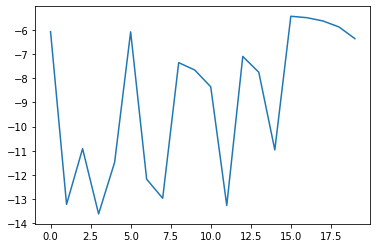

In [34]:
plt.plot((history['mse']))

In [131]:
shape

(1024, 128, 12)

In [38]:
init_data = jax.random.normal(rng, shape=(1,) + x_val.reshape(-1, 128).shape, dtype=np.float32)

In [41]:
init_data.shape

(1, 12288, 128)

In [48]:
key,rng,z_rng = jax.random.split(rng, num=3)

input_shape = (12,) + shape + (1,)

model = get_model()

#x_val =  jnp.expand_dims(jnp.concatenate(pca3[4:]), -1)
#y_val =  jnp.expand_dims(jnp.concatenate(cosmo_tiles[4:]), -1)

# OUTPUTS
n_batches = x_val.shape[0] // batch_size

preds = []

#for i in range(n_batches):
y_pred = get_model().apply({'params': params}, _x_val[:batch_size])

input shape (1, 12288, 128)
evecs (128, 128)
evec outshape (128, 128)
output shape (1, 12288, 128)


In [43]:
y_pred = np.squeeze(np.concatenate(preds))

In [44]:
y_pred.shape

(85, 12288, 128)

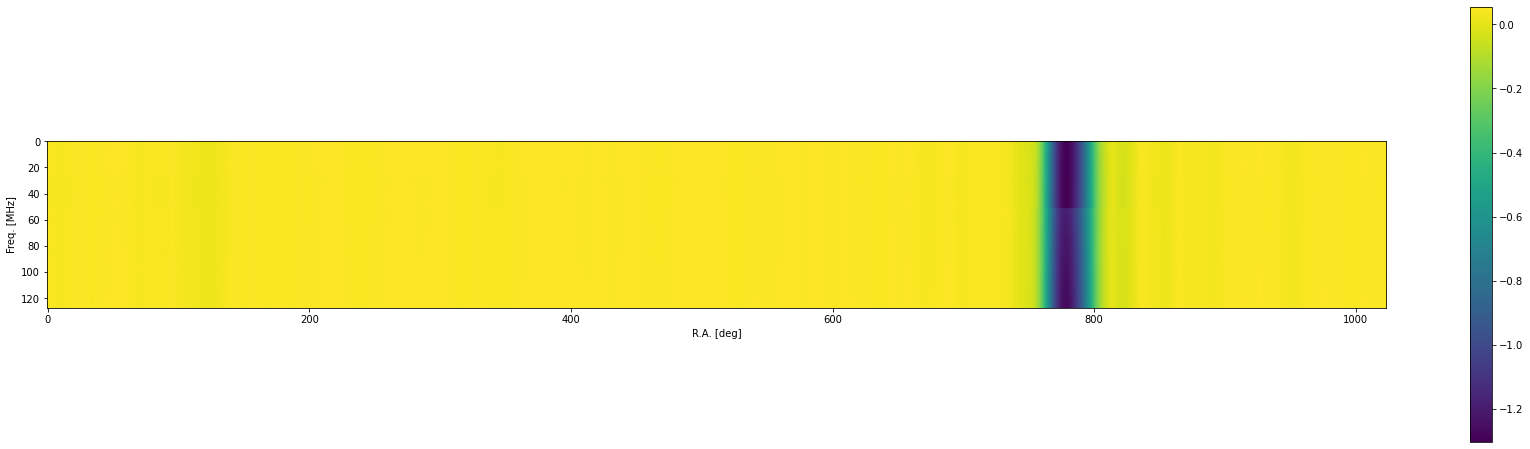

In [47]:
plt.figure(figsize=(30, 8))
plt.imshow(jnp.arcsinh(y_pred[3].reshape(1024, 12, 128))[:, 6, :].T)
#plt.title(r'$\arcsinh|\mathcal{V}|$; ' + baseline_tag)
plt.ylabel('Freq. [MHz]')
plt.xlabel('R.A. [deg]')
plt.colorbar()

In [136]:
xval_c1.shape

(12, 128, 1024)

/softs/intelpython/intelpython3-2020.4-912/intelpython3/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


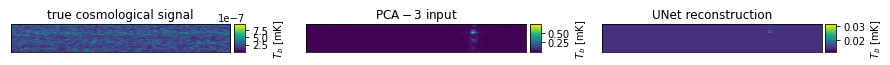

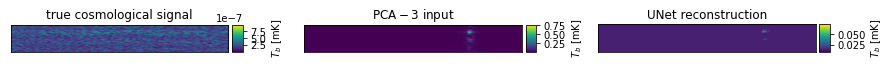

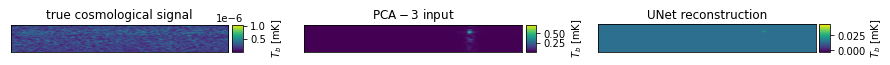

In [142]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

x_test = x_val
y_test = y_val


# which baselines we want to plot
nu_indx = [0, 5, 11]
for nu in nu_indx:
  #pick = 0

  xval_c1 = np.squeeze(x_test).T #[:, :, nu]
  yval_c1 = np.squeeze(y_test).T #[:, :, nu]
  y_c1_pred = np.squeeze(y_pred).T

  fig,axs = plt.subplots(constrained_layout=True)

  ax1 = plt.subplot(131)
  im = ax1.imshow(yval_c1[nu], rasterized=True, 
                  interpolation='spline16')

  # create an axes on the right side of ax. The width of cax will be 5%
  # of ax and the padding between cax and ax will be fixed at 0.05 inch.
  divider = make_axes_locatable(ax1)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  cbar = plt.colorbar(im, cax=cax)
  cbar.set_label(r'$T_b\ \rm [mK]$')
  ax1.set_xticks([])
  ax1.set_yticks([])
  ax1.set_title(r"true cosmological signal")


  ax1 = plt.subplot(132)
  im = plt.imshow(xval_c1[nu], rasterized=True, 
                  interpolation='spline16')

  # create an axes on the right side of ax. The width of cax will be 5%
  # of ax and the padding between cax and ax will be fixed at 0.05 inch.
  divider = make_axes_locatable(ax1)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  cbar = plt.colorbar(im, cax=cax)


  cbar.set_label(r'$T_b\ \rm [mK]$')
  ax1.set_xticks([])
  ax1.set_yticks([])
  ax1.set_title(r"$\rm PCA-3 $ input")



  ax1 = plt.subplot(133)
  im = plt.imshow(y_c1_pred[nu], rasterized=True, 
                  interpolation='spline16')

  divider = make_axes_locatable(ax1)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  cbar = plt.colorbar(im, cax=cax)

  cbar.set_label(r'$T_b\ \rm [mK]$')

  ax1.set_xticks([])
  ax1.set_yticks([])
  ax1.set_title(r"UNet reconstruction")


  #plt.suptitle(r'$\nu = $%03d'%(nu_arr[nu]) + r' $\rm MHz$')

  plt.gcf().set_size_inches((3.7* 3.37, 3.37))
    
  plt.tight_layout()

  plt.show()

In [18]:
x_test = x_val
y_test = y_val

In [19]:
def pca(X):
  # Data matrix X, assumes 0-centered
  n, m = X.shape
  assert jnp.allclose(X.mean(axis=0), np.zeros(m))
  # Compute covariance matrix
  C = jnp.dot(X.T, X) / (n-1)
  # Eigen decomposition
  eigen_vals, eigen_vecs = jnp.linalg.eig(C)
  # Project X onto PC space
  X_pca = jnp.dot(X, eigen_vecs)
  return X_pca

In [36]:
@jax.jit
def pca(X):
  # Data matrix X, assumes 0-centered
  n, m = X.shape
  #assert jnp.allclose(X.mean(axis=0), jnp.zeros(m))
  # Compute covariance matrix
  C = jnp.dot(X.T, X) / (n-1)
  # Eigen decomposition
  eigen_vals, eigen_vecs = jnp.linalg.eigh(C)
  # Project X onto PC space
  X_pca = jnp.dot(X, eigen_vecs)
  return X_pca

In [338]:
from sklearn.decomposition import PCA


def dummy_pca_subtraction(X, n_comp):
    
    n,m = X.shape
    
    # initialize the PCA algorithm
    pca = PCA()
    
    # allocate the output array
    #if output_shape is None:
    #    pca_reduced_out = np.zeros(input_map.shape)
    #else:
    #    pca_reduced_out = np.zeros(output_shape)

  
    # do PCA removal of n_comp components
    pca.fit(X)
    X_pca = pca.transform(X)
    ind_arr = np.reshape(np.arange(n*m),X.shape)

  
    mask = np.ones(X_pca.shape)
    for i in range(n_comp, X_pca.shape[1]):
        mask[ind_arr%X_pca.shape[1]==i] = 0
        
    X_pca = X_pca*mask
    obs_pca_red = pca.inverse_transform(X_pca)
    print("Now I'm doing the minimum subtraction...")
    print("...removing the first %d principal components"%(n_comp))
    X_res = X - obs_pca_red
    
    return X_res

In [400]:
noise = jax.random.normal(key, (128,128))

In [478]:
from functools import partial 
@partial(jax.jit, static_argnums=1)
def pca_subtraction(X, n_comp=3):
    # Data matrix X, shaped (-1, featureaxis)
    n, m = X.shape

    # calculate mean
    mu = X.mean(axis=0)

    X -= mu

    # DO PCA 

    # Compute covariance matrix
    C = jnp.dot(X.T, X) / (n-1)
    # Eigen decomposition
    eigen_vals, eigen_vecs = jnp.linalg.eigh(C)
    
    # TEST: TRASFORM EIGENVECS
    #eigen_vecs *= noise
    
    # Project X onto PC space
    X_pca = jnp.dot(X, eigen_vecs)

    ind_arr = jnp.reshape(jnp.arange(n*m),X.shape)

    mask = jnp.ones((n,m))
    component_mask = ind_arr%m
    comps_to_keep = jnp.arange(n_comp, m)
    mask_of_comps_to_keep = jnp.in1d(component_mask.flatten(), 
                                     comps_to_keep).reshape(component_mask.shape) # returns boolean mask

    # now use the mask's mask to set zeros for the stuff we don't want
    # does the same as: for i in range(n_comp, m): mask = mask.at[ind_arr%m == i].set(0.)
    mask = jnp.where(mask_of_comps_to_keep == 0, 0., mask)

    
    X_pca = X_pca*mask


    
    # inverse pca-transform !
    X_pca_inv = jnp.dot(X_pca, eigen_vecs.T)
    
        # the PCA residual   
    X_res = X - X_pca_inv
    

    return X_res, eigen_vecs

In [479]:
transform_control = dummy_pca_subtraction(x_test.reshape(1024*12, 128), n_comp=18)

Now I'm doing the minimum subtraction...
...removing the first 18 principal components


In [480]:
transform_test, evecs = pca_subtraction(x_test.reshape(1024*12, 128), n_comp=18)

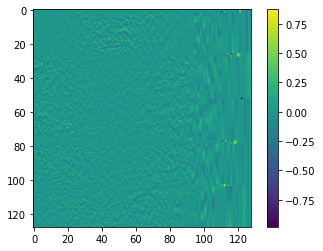

In [483]:
plt.imshow(evecs)
plt.colorbar()

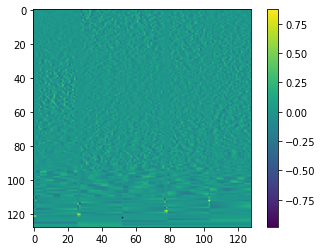

In [484]:
plt.imshow(evecs.T)
plt.colorbar()

In [418]:
baselines = np.array(
    [[  0. ,   8.5, 0],
     [  0. ,  17. , 0],
     [  6.5, -17. , 0],
     [  6.5,  -8.5, 0],
     [  6.5,   0. , 0],
     [  6.5,   8.5, 0],
     [  6.5,  17. , 0],
     [ 13. , -17. , 0],
     [ 13. ,  -8.5, 0],
     [ 13. ,   0. , 0],
     [ 13. ,   8.5, 0],
     [ 13. ,  17. , 0],
     [ 19.5,  -8.5, 0],
     [ 19.5,   0. , 0],
     [ 19.5,   8.5, 0]
     ]
     ) # in ENU metres

In [419]:
ibase = 6
baseline_tag = f'EW:{baselines[ibase, 0]} m, NS:{baselines[ibase, 1]} m'

# Input signal

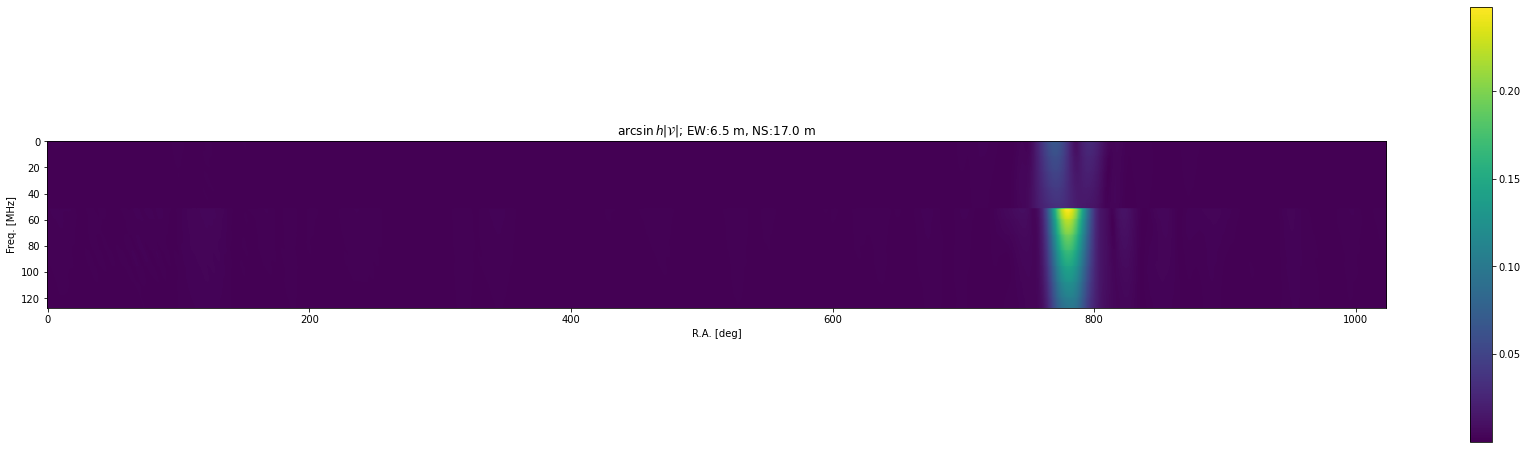

In [433]:
plt.figure(figsize=(30, 8))
plt.imshow(jnp.arcsinh(x_test.reshape(1024, 12, 128))[:, ibase, :].T)
plt.title(r'$\arcsinh|\mathcal{V}|$; ' + baseline_tag)
plt.ylabel('Freq. [MHz]')
plt.xlabel('R.A. [deg]')
plt.colorbar()

# cosmological signal (target)

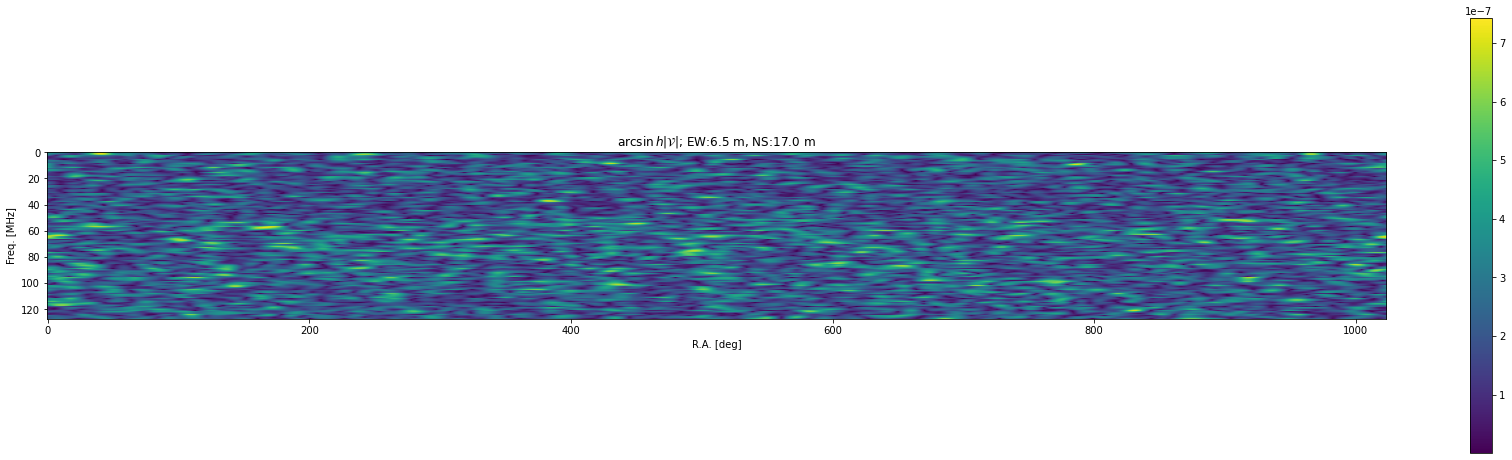

In [432]:
plt.figure(figsize=(30, 8))
plt.imshow(jnp.arcsinh(y_val.reshape(1024, 12, 128))[:, 6, :].T)
plt.title(r'$\arcsinh|\mathcal{V}|$; ' + baseline_tag)
plt.ylabel('Freq. [MHz]')
plt.xlabel('R.A. [deg]')
plt.colorbar()

# sklearn PCA

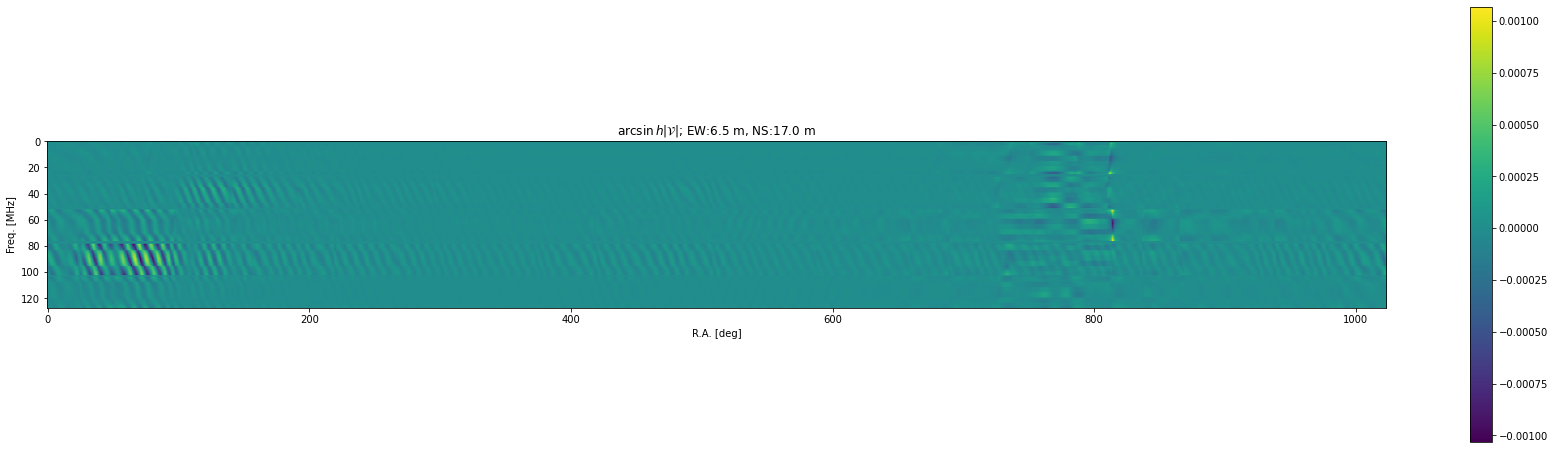

In [430]:
plt.figure(figsize=(30, 8))
plt.imshow(jnp.arcsinh(transform_control.reshape(1024, 12, 128))[:, ibase, :].T)
plt.title(r'$\arcsinh|\mathcal{V}|$; ' + baseline_tag)
plt.ylabel('Freq. [MHz]')
plt.xlabel('R.A. [deg]')
plt.colorbar()

# Jax PCA (vanilla)

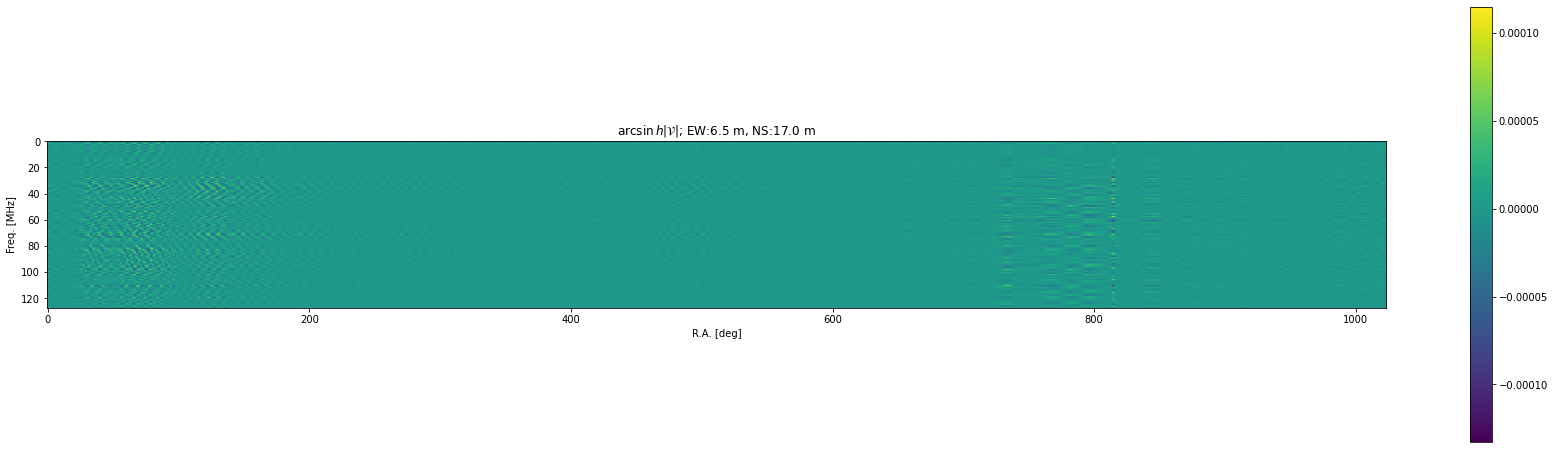

In [431]:
plt.figure(figsize=(30, 8))
plt.imshow(jnp.arcsinh(transform_test.reshape(1024, 12, 128))[:, ibase, :].T)
plt.title(r'$\arcsinh|\mathcal{V}|$; ' + baseline_tag)
plt.ylabel('Freq. [MHz]')
plt.xlabel('R.A. [deg]')
plt.colorbar()

In [169]:
np.sum(x_test.flatten() - transform.flatten())

DeviceArray(5745.236, dtype=float32)

In [80]:
transform.shape

(12288, 128)

In [29]:
x_test = x_val.reshape(1024, 12, 128)

In [45]:
x_test.reshape(-1, 128).mean(axis=0)

array([0.00333646, 0.00338955, 0.00326998, 0.00324739, 0.00319708,
       0.00317485, 0.00315265, 0.00313052, 0.00309887, 0.00307692,
       0.00305506, 0.00303326, 0.00298175, 0.00296019, 0.00293876,
       0.00291746, 0.00287186, 0.00285125, 0.00283085, 0.00281069,
       0.00278187, 0.00276214, 0.00274263, 0.00272333, 0.0026783 ,
       0.0026596 , 0.00432823, 0.00442036, 0.004571  , 0.00453499,
       0.00449923, 0.00446372, 0.00441433, 0.00437942, 0.00434476,
       0.00431038, 0.00421239, 0.00417939, 0.00414672, 0.00411439,
       0.00406079, 0.00402925, 0.00399798, 0.00396697, 0.00392242,
       0.00389201, 0.00386186, 0.00383197, 0.00374903, 0.00372022,
       0.00369164, 0.00366335, 0.00423314, 0.00483623, 0.00479501,
       0.00475429, 0.00468047, 0.00464115, 0.00460225, 0.00456378,
       0.00446625, 0.00442926, 0.00439267, 0.00435647, 0.00430067,
       0.00426547, 0.00423065, 0.0041962 , 0.00413351, 0.00410008,
       0.00406698, 0.00403423, 0.00395084, 0.00391931, 0.00388

In [34]:
blah = jnp.dot(x_test.reshape(-1, 128).T, x_test.reshape(-1, 128)).shape

In [35]:
eigen_vals, eigen_vecs = jnp.linalg.eig(blah)

ValueError: Argument to nonsymmetric eigendecomposition must have shape [..., n, n], got shape (2,)

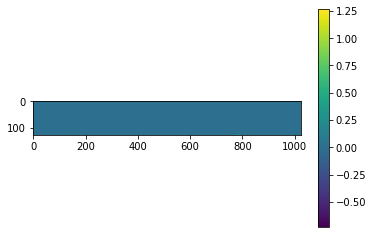

In [44]:
plt.imshow(transform.reshape(1024, 12, 128)[:, 0, :].T)
plt.colorbar()

In [5]:
def svd(X):
  # Data matrix X, X doesn't need to be 0-centered
  n, m = X.shape
  # Compute full SVD
  U, Sigma, Vh = np.linalg.svd(X, 
      full_matrices=False, # It's not necessary to compute the full matrix of U or V
      compute_uv=True)
  # Transform X with SVD components
  X_svd = np.dot(U, np.diag(Sigma))
  return X_svd

In [146]:
x_test.shape

(1024, 128, 12)

In [168]:
import jax.numpy as jnp
import jax.scipy as jsp

def jnp_svd(X):
    # Compute full SVD
    U, Sigma, Vh = jnp.linalg.svd(X, 
                                  full_matrices=False, # It's not necessary to compute the full matrix of U or V
                                  compute_uv=True,
                                 )
    return U, Sigma, Vh

def jsp_svd(X):
    U, Sigma, Vh = jsp.linalg.svd(X, 
                                  full_matrices=False,
                                  compute_uv=True,
                                  check_finite=False,
                                  overwrite_a=True
                                 )
    return U, Sigma, Vh

def jnp_svd_subtraction(X):
    

  U, Sigma, Vh = jnp.linalg.svd(X, 
                                  full_matrices=False,
                                  compute_uv=True,
                                 )

  #principal_comps = U*Sigma
    
  # Transform X with SVD components
  X_svd = np.dot(U, np.diag(Sigma))
  return X_svd

In [ ]:
    # initialize the PCA algorithm
    pca = PCA()
    
    # allocate the output array
    if output_shape is None:
        pca_reduced_out = np.zeros(input_map.shape)
    else:
        pca_reduced_out = np.zeros(output_shape)

  
    # do PCA removal of n_comp components
    pca.fit(input_map)
    obs_pca = pca.transform(input_map)
    ind_arr = np.reshape(np.arange(np.prod(np.array(obs_pca.shape))),obs_pca.shape)

  
    mask = np.ones(obs_pca.shape)
    for i in range(n_comp, obs_pca.shape[1]):
        mask[ind_arr%obs_pca.shape[1]==i] = 0
        
    obs_pca = obs_pca*mask
    obs_pca_red = pca.inverse_transform(obs_pca)
    print("Now I'm doing the minimum subtraction...")
    print("...removing the first %d principal components"%(n_comp))
    obs_pca_red = input_map - obs_pca_red

In [172]:
x_test.shape

(1024, 128, 12)

In [175]:
x_svd = jnp_svd_subtraction(x_test.reshape(1024*12, 128))

In [176]:
x_svd.shape

(12288, 128)

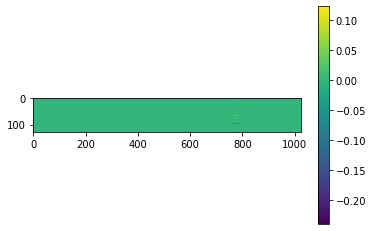

In [183]:
plt.imshow(x_svd.reshape(1024, 128, 12)[:, :, 3].T)
plt.colorbar()

In [157]:
Vh.shape

(1024, 12, 12)

In [151]:
Sigma.shape

(1024, 12)

In [156]:
np.square(Sigma) / (n - 1)

NameError: name 'n' is not defined

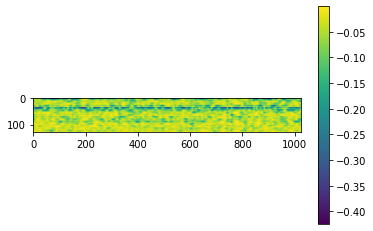

In [155]:
plt.imshow(U[:, :, 0].T)
plt.colorbar()